In this notebook we investigate the transitions that a crystal of ultra-cold ions in a Penning trap undergoes as the rotation frequency of the ions in the trap is increased. As the rotation frequency increases, the radial confinement becomes stronger. Eventually it becomes energetically favourable, to stack several crystal of ions on top of one another. The frequencies at which these transitions occur are well understood theoretically and serve as a verification of the numerical integration of the ions motion.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines
import numpy as np
import mode_analysis_code
import coldatoms

First we need to find an initial configuration of the ions close to their ground state

In [69]:
mode_analysis = mode_analysis_code.ModeAnalysis(N=127,
                                                Vtrap=(0.0, -1750.0, -1970.0),
                                                Vwall=1.0,
                                                frot=185.0)

In [70]:
mode_analysis.run()

<IPython.core.display.Javascript object>


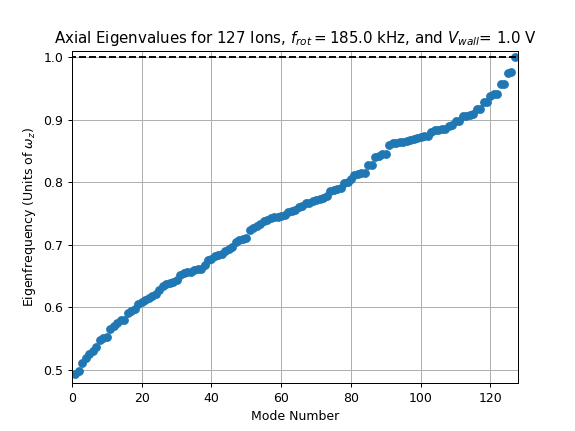

In [71]:
mode_analysis.show_axial_Evals();

In [72]:
def create_ensemble(uE, omega_z, mass, charge):
    num_ions = int(uE.size / 2)
    x = uE[:num_ions]
    y = uE[num_ions:]
    r = np.sqrt(x**2 + y**2)
    r_hat = np.transpose(np.array([x / r, y / r]))
    phi_hat = np.transpose(np.array([-y / r, x / r]))
    v = np.zeros([num_ions, 2], dtype=np.float64)
    for i in range(num_ions):
        v[i, 0] = omega_z * r[i] * phi_hat[i, 0]
        v[i, 1] = omega_z * r[i] * phi_hat[i, 1]
    
    ensemble = coldatoms.Ensemble(num_ions)
    for i in range(num_ions):
        ensemble.x[i, 0] = x[i]
        ensemble.x[i, 1] = y[i]
        ensemble.x[i, 2] = 0.0
        ensemble.v[i, 0] = v[i, 0]
        ensemble.v[i, 1] = v[i, 1]
        ensemble.v[i, 2] = 0.0
    
    ensemble.ensemble_properties['mass'] = mass
    ensemble.ensemble_properties['charge'] = charge
    
    return ensemble

# Forces

In [73]:
coulomb_force = coldatoms.CoulombForce()

class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi_0 = phi_0
        self.phi = phi_0
        self.omega = omega

    def reset_phase(self):
        self.phi = self.phi_0
            
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * x + cphi * sphi * (ky - kx) * y)
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * x + (-kx * sphi * sphi - ky * cphi * cphi) * y)
        f[:, 2] += -dt * q *self.kz * z

        self.phi += self.omega * 0.5 * dt

trap_potential = TrapPotential(2.0 * mode_analysis.Coeff[2], mode_analysis.Cw, mode_analysis.wrot, np.pi / 2.0)

After we change the rotation frequency we need the ions to settle into a new steady state. This requires a damping of the azimuthal motion of the ions. In the rotating frame, the ions should settle to a state where they co-rotate with the trap at the new frequency.

In [74]:
class AngularDamping(object):

    def __init__(self, omega, kappa_theta):
        self.omega = omega
        self.kappa_theta = kappa_theta
            
    def dampen(self, dt, ensemble):
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        vx = ensemble.v[:, 0]
        vy = ensemble.v[:, 1]
        vz = ensemble.v[:, 2]
        
        expMinusKappaDt = np.exp(-self.kappa_theta * dt)
        
        for i in range(ensemble.num_ptcls):
            r = np.sqrt(x[i] * x[i] + y[i] * y[i])
            v = np.array([vx[i], vy[i]])
            v_hat = np.array([-y[i], x[i]]) / r
            v_par = v_hat.dot(v) * v_hat
            v_perp = v - v_par
            v_target = self.omega * r * v_hat
            
            v_updated = v_perp + v_target + (v_par - v_target) * expMinusKappaDt
            ensemble.v[i, 0] = v_updated[0]
            ensemble.v[i, 1] = v_updated[1]

In [88]:
class AxialDamping(object):
    """Doppler cooling along z without recoil."""

    def __init__(self, kappa):
        """kappa is the damping rate."""
        self.kappa = kappa
            
    def dampen(self, dt, ensemble):
        vz = ensemble.v[:, 2]

        damping_factor = np.exp(-self.kappa * dt)
        
        ensemble.v[:, 2] =  damping_factor * vz

In [75]:
def evolve_ensemble_with_damping(dt, t_max, ensemble, Bz, forces, dampings):
    t = 0
    while t < t_max:
        coldatoms.bend_kick(dt, Bz, ensemble, forces, num_steps=1)
        for d in dampings:
            d.dampen(dt, ensemble)
        t += dt

In [76]:
def radius(x):
    return np.sqrt(x[:, 0]**2 + x[:, 1]**2)

def speed(v):
    return np.sqrt(v[:, 0]**2 + v[:, 1]**2 + v[:, 2]**2)

def radial_velocity(x, v):
    num_ptcls = v.shape[0]
    velocity = np.zeros(num_ptcls)
    for i in range(num_ptcls):
        r_hat = np.copy(x[i, :2])
        r_hat /= np.linalg.norm(r_hat)
        velocity[i] = r_hat.dot(v[i, :2])
    return velocity

def angular_velocity(x, v):
    num_ptcls = v.shape[0]
    velocity = np.zeros(num_ptcls)
    for i in range(num_ptcls):
        r_hat = np.copy(x[i, :2])
        r_hat /= np.linalg.norm(r_hat)
        v_r = r_hat * (r_hat.dot(v[i, :2]))
        velocity[i] = np.linalg.norm(v[i, :2] - v_r)
    return velocity

In [79]:
def evolve_to_steady_state(dt=1.0e-9, t_max=1.0e-8, dampings=[],
                           omega=2.0 * np.pi * 180.0e3, vz_perturbation=1.0e-3):
    my_ensemble = create_ensemble(mode_analysis.uE,
                                  omega,
                                  mode_analysis.m_Be,
                                  mode_analysis.q)
    my_ensemble.v[:, 2] += np.random.normal(loc=0.0, scale=vz_perturbation, size=my_ensemble.num_ptcls)

    x_0 = np.copy(my_ensemble.x)
    v_0 = np.copy(my_ensemble.v)
    
    trap_potential.phi = np.pi / 2.0
    trap_potential.omega = omega

    evolve_ensemble_with_damping(
        dt,
        t_max,
        my_ensemble,
        mode_analysis.B,
        [coulomb_force, trap_potential],
        dampings)
    
    return (my_ensemble, x_0, v_0)

9.00900900900901e-05


<IPython.core.display.Javascript object>


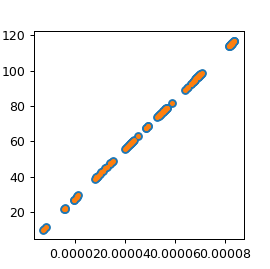

In [80]:
omega = 1.2 * mode_analysis.wrot
t_max = 2.0e1 * 2.0 * np.pi / omega
dt=1.0e-9
print(t_max)
kappa = 1.0e7
my_ensemble, x0, v0 = evolve_to_steady_state(t_max=t_max, dt=dt, omega=omega,
                                             dampings=[AngularDamping(omega, kappa)]);


<IPython.core.display.Javascript object>


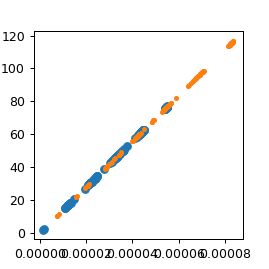

In [81]:
plt.figure(figsize=(3,3))
plt.plot(radius(my_ensemble.x), angular_velocity(my_ensemble.x, my_ensemble.v), 'o')
plt.plot(radius(x0), omega * radius(x0), '.')

<IPython.core.display.Javascript object>


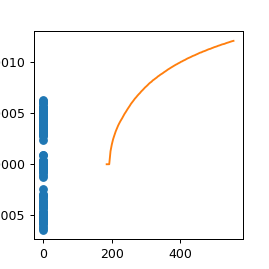

In [82]:
plt.figure(figsize=(3,3))
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,2], 'o')


In [86]:
np.std(my_ensemble.x[:,2])

4.2552197402670326e-06

In [96]:
w = mode_analysis.wrot
omegas = np.linspace(w, 3.0 * w, 5)
thicknesses = []
for omega in omegas:
    t_max = 8.0e0 * 2.0 * np.pi / omega
    dt=1.0e-9
    kappa = 5.0e6
    my_ensemble, x0, v0 = evolve_to_steady_state(t_max=t_max, dt=dt, omega=omega,
                                             dampings=[AngularDamping(omega, kappa), AxialDamping(0.1 * kappa)])
    thickness = np.std(my_ensemble.x[:,2])
    print(omega, thickness)
    thicknesses.append(thickness)
thicknesses = np.array(thicknesses)
print(omegas)
print(thicknesses)

1162389.28183 1.72952457702e-15
1185871.89358 2.87172627395e-15
1209354.50534 1.26751714866e-09
1232837.11709 1.27977091509e-06
1256319.72884 1.93365751671e-06
1279802.3406 2.4470257445e-06
1303284.95235 2.83558967018e-06
1326767.56411 3.20797385148e-06
1350250.17586 3.51460394558e-06
1373732.78762 3.81273424743e-06
1397215.39937 4.06276084399e-06
1420698.01112 4.29454629089e-06
1444180.62288 4.49942805683e-06
1467663.23463 4.73145798231e-06
1491145.84639 4.95930129363e-06
1514628.45814 5.14855394119e-06
1538111.06989 5.35573985432e-06
1561593.68165 5.54899154667e-06
1585076.2934 5.73535641992e-06
1608558.90516 5.93955293917e-06
1632041.51691 6.10181068267e-06
1655524.12866 6.26544573113e-06
1679006.74042 6.44006441125e-06
1702489.35217 6.57790133034e-06
1725971.96393 6.73283060197e-06
1749454.57568 6.87335558686e-06
1772937.18743 6.99985853734e-06
1796419.79919 7.1543393289e-06
1819902.41094 7.27564122491e-06
1843385.0227 7.40969563688e-06
1866867.63445 7.54721250588e-06
1890350.24621

In [97]:
omegas=np.linspace(w, 3.0 * w, 100)

<IPython.core.display.Javascript object>


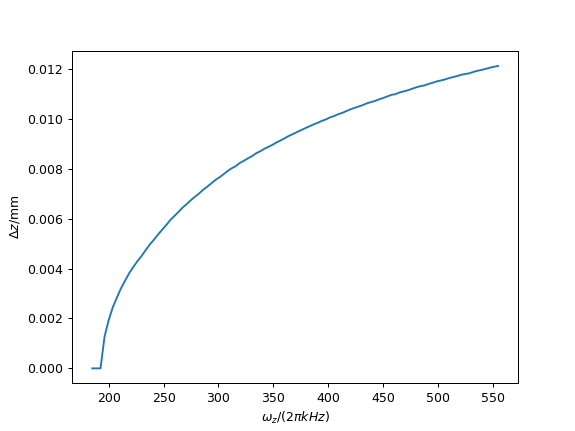

In [100]:
plt.figure()
plt.plot(omegas/(2.0*np.pi*1.0e3), thicknesses*1.0e3)
plt.xlabel(r'$\omega_z/(2\pi kHz)$')
plt.ylabel(r'$\Delta z/{\rm mm}$')

<IPython.core.display.Javascript object>


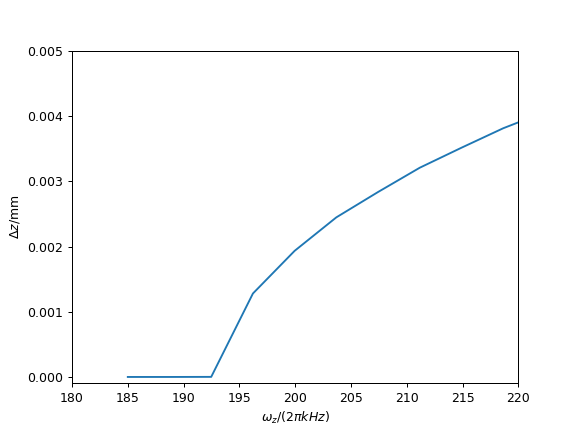

In [103]:
plt.figure()
plt.plot(omegas/(2.0*np.pi*1.0e3), thicknesses*1.0e3)
plt.xlim([180, 220])
plt.ylim([-1.0e-4,5.0e-3])
plt.xlabel(r'$\omega_z/(2\pi kHz)$')
plt.ylabel(r'$\Delta z/{\rm mm}$')